# vcc792_bin.ipynb

### Isaac Cheng - September 2021

Various plots of VCC 792 with binning. Read [this webpage](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/docs/ngvsdoc.html) for lots of useful information! Also look at [this PDF](https://www.ucolick.org/~bolte/AY257/s_n.pdf) for a useful overview of CCD signal/noise satistics. Also read the section on binning.

Also: [Astropy Course](https://www.iasf-milano.inaf.it/astropy-course/), in particular, see the [Astropy image walkthrough](https://www.iasf-milano.inaf.it/AstropyCourse/07.Images.slides.html).

[vorbin manual](https://www-astro.physics.ox.ac.uk/~mxc/software/vorbin_manual.pdf) and [Michele Cappellari's Python Programs page](http://www-astro.physics.ox.ac.uk/~mxc/software/)


In [1]:
# # May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"

/arc/home/IsaacCheng/coop_f2021/warmup


# Voronoi Binning


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.wcs import WCS
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import plotbin
import fits_plot_utils as utils
%matplotlib widget

In [4]:
# 
# Load data
# 
vcc792_dist = 16.5 * u.Mpc
# Signal
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# Noise
noise_i, header_noise_i = utils.load_img(inoise_path)
noise_g, header_noise_g = utils.load_img(gnoise_path)
noise_u, header_noise_u = utils.load_img(unoise_path)
# 
# Cut out galaxy
# 
vcc792_center = (2716, 1613)
vcc792_shape = (1480, 1127)
data_i_cut, wcs_i_cut = utils.cutout(data_i, vcc792_center, vcc792_shape, header=header_i)
data_g_cut, wcs_g_cut = utils.cutout(data_g, vcc792_center, vcc792_shape, header=header_g)
data_u_cut, wcs_u_cut = utils.cutout(data_u, vcc792_center, vcc792_shape, header=header_u)
noise_i_cut, wcs_noise_i_cut = utils.cutout(noise_i, vcc792_center, vcc792_shape, header=header_noise_i)
noise_g_cut, wcs_noise_g_cut = utils.cutout(noise_g, vcc792_center, vcc792_shape, header=header_noise_g)
noise_u_cut, wcs_noise_u_cut = utils.cutout(noise_u, vcc792_center, vcc792_shape, header=header_noise_u)
# 
# VERTICO CO Data
# 
co_path = "/arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits"
data_co, header_co = utils.load_img(co_path)

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_690

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [7]:
def calc_colour_err(blue, red, blue_err, red_err):
    """
    Calculates the uncertainty in the colour index using basic uncertainty propagation.
    The colour, or colour index, is defined as:
                        colour = -2.5 * log10(blue / red)
    where blue is the flux in the shorter wavelength band and red is the flux in the
    longer wavelength band.
    The uncertainty, assuming independent errors and to a first-order approximation, is
    given by:
            colour_err^2 = (-2.5/ln(10) * 1/blue)^2 * blue_err^2 +
                           (+2.5/ln(10) * 1/red)^2 * red_err^2
                         = (2.5/ln(10))^2 * [(blue_err/blue)^2 + (red_err/red)^2]
    Thus:
            colour_err = sqrt(colour_err^2)
                       = 2.5 / ln(10) * sqrt((blue_err/blue)^2 + (red_err/red)^2)
    Note that all the parameters MUST be able to broadcast together.

    Parameters:
      blue :: array
        The flux in the shorter wavelength band
      red :: array
        The flux in the longer wavelength band
      blue_err :: array
        The uncertainty in the flux in the shorter wavelength band
      red_err :: array
        The uncertainty in the flux in the longer wavelength band
        
    Returns: colour_err
      colour_err :: array
        The uncertainty in the colour index.
    """
    prefactor = (2.5 / np.log(10))
    errs = np.sqrt((blue_err / blue) ** 2 + (red_err / red) ** 2)
    return prefactor * errs

## g-i Colour


/tmp/ipykernel_5252/2695765242.py:2: RuntimeWarning: invalid value encountered in log10
  gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)
/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


(1480, 1127)


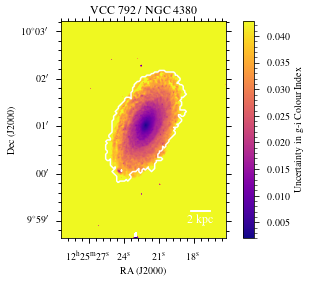

In [48]:
%matplotlib inline
gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)
gi_colour_err = calc_colour_err(data_g_cut, data_i_cut, noise_g_cut, noise_i_cut)
y_coords, x_coords = np.meshgrid(
    np.arange(gi_colour.shape[0]), np.arange(gi_colour.shape[1])
)
x_coords, y_coords = x_coords.T, y_coords.T
is_good = np.isfinite(gi_colour_err)  # some pixels of the sigma maps are not finite
print(gi_colour.shape)
# print(x_coords.shape)
# print(x_coords)
# print(np.sum(~np.isfinite(data_g_cut)))
# print(np.sum(~np.isfinite(data_i_cut)))
# print(np.sum(~np.isfinite(noise_g_cut)))
# print(np.sum(~np.isfinite(noise_i_cut)))
# print(np.sum(~np.isfinite(gi_colour_err)))
# ! LARGE IMAGE! Voronoi binning takes a long time. See method docstring
# voronoi_2d_binning(
#     x_coords[is_good],
#     y_coords[is_good],
#     gi_colour[is_good],
#     gi_colour_err[is_good],
#     targetSN=50,
#     pixelsize=100
# )
# 
# 
# 
cmap = "plasma"
cmap = mpl.cm.get_cmap(cmap)
#
fig, ax = plt.subplots(subplot_kw={"projection": wcs_i_cut})
# fig, ax = plt.subplots()
# img = ax.imshow(gi_colour, cmap=cmap, vmin=0.5, vmax=1.6)
img = ax.imshow(gi_colour_err, cmap=cmap, vmax=np.percentile(gi_colour_err[is_good], 15))
utils.add_scalebar(ax, wcs_i_cut, vcc792_dist,
                   scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
# cbar.set_label("g-i Colour Index")
cbar.set_label("Uncertainty in g-i Colour Index")
#
# Overplot CO contours from VERTICO data
#
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/vcc792_contour1_g-i.pdf")
plt.show()


In [25]:
plt.close("all")